#### Compute topological barcodes for week 3 data (well A08)

- **Authors:** Zachary Neronha and Dhananjay Bhaskar
- **Last Modified:** 2 APR 2019 (ZN, DB) 
- **Wong Lab**, Brown University

#### Load required packages

In [83]:
library(TDA)
library(grid)
library(repr)
library(pracma)
library(stringr)
library(extrafont)
library(latex2exp)
library(Cairo)

library("fpc")
library("ripserr")
library("graphics")
library("ggplot2")
library("scatterplot3d")

loadfonts(quiet = TRUE)
loadfonts(device = "postscript", quiet = TRUE)

names(postscriptFonts())

set.seed(123)

packageVersion("TDA")

[1] "serif"                      "sans"                      
 [3] "mono"                       "AvantGarde"                
 [5] "Bookman"                    "Courier"                   
 [7] "Helvetica"                  "Helvetica-Narrow"          
 [9] "NewCenturySchoolbook"       "Palatino"                  
[11] "Times"                      "URWGothic"                 
[13] "URWBookman"                 "NimbusMon"                 
[15] "NimbusSan"                  "URWHelvetica"              
[17] "NimbusSanCond"              "CenturySch"                
[19] "URWPalladio"                "NimbusRom"                 
[21] "URWTimes"                   "ArialMT"                   
[23] "ComputerModern"             "ComputerModernItalic"      
[25] "Japan1"                     "Japan1HeiMin"              
[27] "Japan1GothicBBB"            "Japan1Ryumin"              
[29] "Korea1"                     "Korea1deb"                 
[31] "CNS1"                       "GB1"                       
[33] "Amiri"                      "Amiri Quran"               
[35] "Carlito"                    "DejaVu Sans"               
[37] "DejaVu Sans Condensed"      "DejaVu Sans Light"         
[39] "DejaVu Sans Mono"           "DejaVu Serif"              
[41] "DejaVu Serif Condensed"     "EB Garamond 08"            
[43] "EB Garamond 08 SC"          "EB Garamond 12"            
[45] "EB Garamond Initials Fill1" "EB Garamond Initials Fill2"
[47] "FontAwesome"                "FreeMono"                  
[49] "FreeSans"                   "FreeSerif"                 
[51] "Gentium"                    "GentiumAlt"                
[53] "Gentium Basic"              "Gentium Book Basic"        
[55] "Gentium Plus"               "IPAexGothic"               
[57] "IPAexMincho"                "IPAGothic"                 
[59] "IPAMincho"                  "IPAPGothic"                
[61] "IPAPMincho"                 "Junicode"                  
[63] "Lato Black"                 "Lato"                      
[65] "Lato Hairline"              "Lato Heavy"                
[67] "Lato Light"                 "Lato Medium"               
[69] "Lato Semibold"              "Lato Thin"                 
[71] "Liberation Mono"            "Liberation Sans"           
[73] "Liberation Sans Narrow"     "Liberation Serif"          
[75] "Myriad Pro"                 "CM Roman"                  
[77] "CM Roman Asian"             "CM Roman CE"               
[79] "CM Roman Cyrillic"          "CM Roman Greek"            
[81] "CM Sans"                    "CM Sans Asian"             
[83] "CM Sans CE"                 "CM Sans Cyrillic"          
[85] "CM Sans Greek"              "CM Symbol"                 
[87] "CM Typewriter"              "CM Typewriter Asian"       
[89] "CM Typewriter CE"           "CM Typewriter Cyrillic"    
[91] "CM Typewriter Greek"

[1] ‘1.6.4’

#### Ripser setup

In [21]:
## Parse raw output from Ripser
parseOutput = function( output ){
    
    ## Number of intervals by dimension
    indices            = grep( "persistence intervals in dim " , output , value = FALSE )
    maxDimension       = length( indices ) - 1
    indices            = c( indices , length( output ) )
    
    ## Convert output in matrix
    diagram = matrix(, ncol = 3, nrow = 0 )
    
    ## Loop each group of intervals by dimension
    for( dim in 0:maxDimension ){
        
        ## Select intervals
        if( dim == maxDimension ){
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] ) ]
        }else{
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] - 1 ) ]
        }
        
        ## Removed lines from output
        intervals = grep( "\\[\\d*\\.?\\d+\\,\\d*\\.?\\d+\\)" , intervals , value = TRUE )
        
        ## Remove punctuation from intervals
        intervals = gsub( "(\\s|\\[|\\))" , "" , intervals )
        
        ## Split interval and convert to numeric
        intervals = as.numeric( unlist( strsplit( intervals , "," ) ) )
        
        ## Convert ouput in matrix
        intervals = matrix( intervals , ncol = 2 , byrow = T )
        
        ## Add dimension column
        intervals = cbind( rep( dim , nrow( intervals ) ) , intervals )
        
        ## Add intervals to diagram
        diagram = rbind( diagram, intervals )
        
    }
    
    ## Format matrix to diagram format
    colnames( diagram ) = c( "dimension" , "Birth" , "Death" )
    
    return( diagram )    
}

## Calculate rips diagram using Ripser library
ripserDiag = function( X, dimension, threshold, format = "point-cloud" ){
    
    # Ripser likes to read files in, so use a temporary file
    f = tempfile()
    write.table(X, f, col.names = FALSE, row.names = FALSE)
    
    ## Set parameters as text
    dimension = as.character( dimension )
    threshold = as.character( threshold )
    
    ## Run Ripser using system command
    ripserOut = system2("/home/labmember/ripser/ripser", args = c("--dim", dimension, "--threshold", threshold, "--format", format , f), stdout = TRUE)
    
    return( parseOutput( ripserOut ) )
}

#### Custom plotting functions

In [85]:
px2um = 1.0

dim0barcode = function(dimintervals, max_x_lim){
    
    numintervals = dim(dimintervals)[1]
    ymat = linspace(0, 1, n = numintervals + 1)
    y_end = ymat[length(ymat)]
    ymat = ymat[1:length(ymat)-1]
    
    g = ggplot()
    
    bmat = px2um * dimintervals[,2]
    dmat = px2um * dimintervals[,3]
    
    #g = g + geom_point(aes(x = bmat, y = ymat), color = "darkblue", size = 0.3)
    #g = g + geom_point(aes(x = dmat, y = ymat), color = "darkblue", size = 0.3)
    g = g + geom_segment(aes(x = bmat, y = ymat, xend = dmat, yend = ymat), 
                         color = "darkblue", size = 0.8)
    
    # last connected component
    #g = g + geom_point(aes(x = 0, y = y_end), color = "darkblue", size = 0.3)
    g = g + geom_segment(aes(x = 0, y = y_end, xend = max_x_lim, yend = y_end), 
                         arrow = arrow(type = "open", angle = 30, length = unit(0.2, "cm")),
                         color = "darkblue", size = 0.8)
    
    g = g + ylab(TeX('$\\beta_0$')) + xlab(TeX('$\\epsilon$'))
    g = g + xlim(0, max_x_lim) + ylim(-0.1, 1.1) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                 text = element_text(colour = "black", size = 18, family = "Myriad Pro"), 
                 axis.text.x = element_text(colour = "black", size = 15, family = "Myriad Pro"))
    g = g + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 1))
    return(g)
    
}

dim1barcode = function(dimintervals, x_min_lim, x_max_lim){
    
    numintervals = dim(dimintervals)[1]
    ymat = linspace(0,1, n = numintervals + 1)
    y_end = ymat[length(ymat)]
    ymat = ymat[1:length(ymat)-1]
    
    g = ggplot()
    
    bmat = px2um * dimintervals[,2]
    dmat = px2um * dimintervals[,3]
    
    #g = g + geom_point(aes(x = bmat, y = ymat), color = 'red', size = 0.3)
    #g = g + geom_point(aes(x = dmat, y = ymat), color = 'red', size = 0.3)
    g = g + geom_segment(aes(x = bmat, y = ymat, xend = dmat, yend = ymat),
                         color = 'red', size = 0.8)
    
    g = g + ylab(TeX('$\\beta_1$')) + xlab(TeX('$\\epsilon$'))
    g = g + xlim(x_min_lim, x_max_lim) + ylim(-0.1, 1.1) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                 text = element_text(colour = "black", size = 18, family = "Myriad Pro"), 
                 axis.text.x = element_text(colour = "black", size = 15, family = "Myriad Pro"))
    g = g + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 1))
    return(g)
    
}

combinedbarcode = function(dim0intervals, dim1intervals, max_x_lim){
    
    numintervals_b0 = dim(dim0intervals)[1]
    numintervals_b1 = dim(dim1intervals)[1]
    
    ymat = linspace(0, 1, n = (numintervals_b0 + numintervals_b1 + 1))
    
    y_end = ymat[length(ymat)]
    ymat1 = ymat[1:numintervals_b1]
    ymat0 = ymat[(numintervals_b1+1):(length(ymat)-1)]
    
    g = ggplot()
    
    if (numintervals_b1 > 0){
        b1mat = px2um * dim1intervals[,2]
        d1mat = px2um * dim1intervals[,3]

        #g = g + geom_point(aes(x = b1mat, y = ymat1), color = 'red', size = 0.5)
        #g = g + geom_point(aes(x = d1mat, y = ymat1), color = 'red', size = 0.5)
        g = g + geom_segment(aes(x = b1mat, y = ymat1, xend = d1mat, yend = ymat1), 
                             color = 'red', size = 0.8)
    }
    
    b0mat = px2um * dim0intervals[,2]
    d0mat = px2um * dim0intervals[,3]
    
    #g = g + geom_point(aes(x = b0mat, y = ymat0), color = "darkblue", size = 0.5)
    #g = g + geom_point(aes(x = d0mat, y = ymat0), color = "darkblue", size = 0.5)
    g = g + geom_segment(aes(x = b0mat, y = ymat0, xend = d0mat, yend = ymat0), 
                         color = "darkblue", size = 0.8)
    
    # last connected component
    #g = g + geom_point(aes(x = 0, y = y_end), color = "darkblue", size = 0.5)
    g = g + geom_segment(aes(x = 0, y = y_end, xend = max_x_lim, yend = y_end), 
                         arrow = arrow(type = "open", angle = 30, length = unit(0.2, "cm")), 
                         color = "darkblue", size = 0.8)
    
    g = g + ylab(TeX('Barcode ($\\beta_0$, $\\beta_1$)')) + xlab(TeX('$\\epsilon$'))
    g = g + xlim(0, max_x_lim) + ylim(-0.1, 1.1) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                 text = element_text(colour = "black", size = 18, family = "Myriad Pro"), 
                 axis.text.x = element_text(colour = "black", size = 15, family = "Myriad Pro"))
    g = g + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 1))
    return(g)
    
}


persistencediag = function(dim0intervals, dim1intervals, x_max_lim){
    
    g = ggplot()
    
    beta0_bmat = px2um * dim0intervals[,2]
    beta0_dmat = px2um * dim0intervals[,3]
    
    beta1_bmat = px2um * dim1intervals[,2]
    beta1_dmat = px2um * dim1intervals[,3]
    
    g = g + geom_point(aes(x = beta0_bmat, y = beta0_dmat), 
                       color = "darkblue", shape = 1, alpha = 1.0, size = 1.5, stroke = 0.5)
    g = g + geom_point(aes(x = beta1_bmat, y = beta1_dmat), 
                       color = "red", shape = 2, alpha = 1.0, size = 1.5, stroke = 0.5)
    g = g + geom_segment(aes(x = 0, y = 0, xend = x_max_lim, yend = x_max_lim), 
                       color = 'black', size = 0.25)
    
    g = g + ylab("Interval End") + xlab("Interval Start")
    g = g + xlim(0, x_max_lim) + ylim(0, x_max_lim) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                text = element_text(colour = "black", size = 18, family = "Myriad Pro"),
                axis.text.x = element_text(colour = "black", size = 15, family = "Myriad Pro"), 
                axis.text.y = element_text(colour = "black", size = 15, family = "Myriad Pro"))
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 1)) 
    return(g)
    
}

saveepsfig = function(p, w, h, t, fontfamily, fname){
    
    postscript(fname, family = fontfamily, width = w, height = h, title = t)
    plot(p)
    dev.off()
    embed_fonts(fname, outfile = fname)
    
}

#### Load data

In [23]:
d3 = read.csv('Wk3_IMS_TDA/TDAready_a08.csv', header = FALSE)
d3 = d3[,1:2]
dat_A08 = data.matrix(d3)

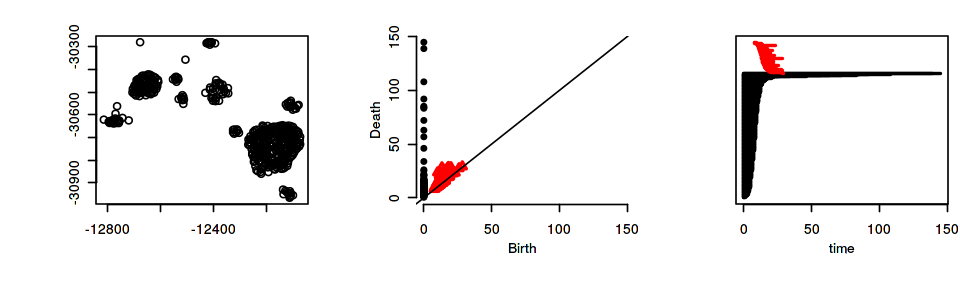

In [51]:
homology2_A08 <- ripserDiag(dat_A08, 1, 500)
intervals_A08 = as.data.frame(homology2_A08)
dim0_A08 = intervals_A08[intervals_A08$dimension==0,]
dim1_A08 = intervals_A08[intervals_A08$dimension==1,]

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=2.5)

plot(d3[,1], d3[,2], mar=c(2,2,2,2), xlab='', ylab='')

TDA::plot.diagram(homology2_A08, barcode = FALSE)
TDA::plot.diagram(homology2_A08, barcode = TRUE)

#### Filter out points above and below cutoff and find clusters using DBSCAN

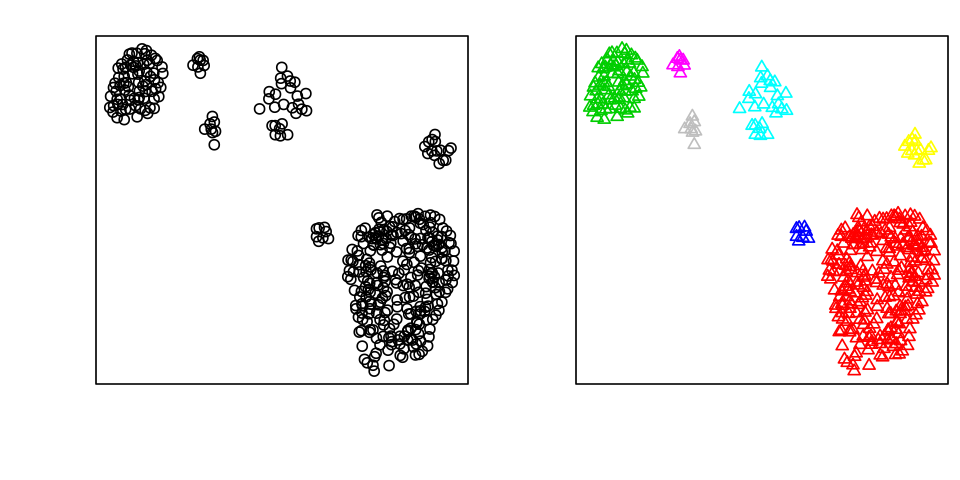

In [34]:
d3_filtered = d3[d3[,2]>(-30870),]
d3_filtered = d3_filtered[d3_filtered[,2]<(-30370),]
d3_filtered = d3_filtered[d3_filtered[,1]>(-12710),]

par(mfrow = c(1, 2), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=4)
plot(d3_filtered,  yaxt='n',  xaxt='n', xlab='', ylab='')

db = fpc::dbscan(d3_filtered, eps = 40, MinPts = 5)
plot(db, d3_filtered, yaxt='n',  xaxt='n', xlab='', ylab='')

#### Compute alpha complex and plot $\beta_0$ barcode and zoomed inset

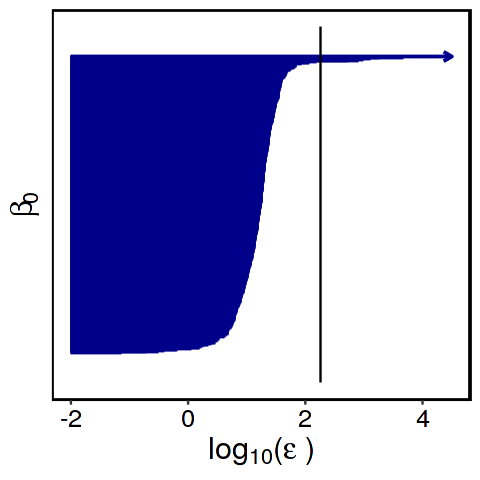

In [90]:
DiagAlphaCmplx = alphaComplexDiag(d3_filtered, maxdimension = 1, library = c("GUDHI","DIONYSUS"),
                                  location = TRUE, printProgress = FALSE)
    
dim0 = DiagAlphaCmplx$diagram[DiagAlphaCmplx$diagram[,1]==0,]
dim1 = DiagAlphaCmplx$diagram[DiagAlphaCmplx$diagram[,1]==1,]

# Order intervals by length
dim0 = dim0[order(dim0[,2],dim0[,3]),]
dim1 = dim1[order(-dim1[,2],-dim1[,3]),]

# Remove the infinite length interval
dim0_finite = dim0[1:(length(dim0[,1])-1),]
dim0_max = max(dim0_finite)

if (dim0[length(dim0[,1]),3]!=Inf){
    print("FAILURE IN INF BARCODE!!!")
    break
}

# Add 1e-2 to transform -Inf values to -2
log_finite = log10(dim0_finite+0.01)

eps_selected = log10(180.350340410428)

options(repr.plot.width=4, repr.plot.height=4)

numintervals = dim(log_finite)[1]
ymat = linspace(0, 1, n = numintervals + 1)
y_end = ymat[length(ymat)]
ymat = ymat[1:length(ymat)-1]

max_x_lim = 4.5

g = ggplot()
    
bmat = log_finite[,2]
dmat = log_finite[,3]

g = g + geom_segment(aes(x = bmat, y = ymat, xend = dmat, yend = ymat), 
                     color = "darkblue", size = 0.8)

g = g + geom_segment(aes(x = -2, y = y_end, xend = max_x_lim, yend = y_end), 
                         arrow = arrow(type = "open", angle = 30, length = unit(0.2, "cm")),
                         color = "darkblue", size = 0.8)

g = g + geom_segment(aes(x = eps_selected, y = -0.1, xend = eps_selected, yend = 1.1), color="black")
    
g = g + ylab(TeX('$\\beta_0$')) + xlab(TeX('$log_{10}(\\epsilon)$'))
g = g + xlim(-2, max_x_lim) + ylim(-0.1, 1.1) + theme_bw()

g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                 text = element_text(colour = "black", size = 18, family = "Myriad Pro"), 
                 axis.text.x = element_text(colour = "black", size = 15, family = "Myriad Pro"))
g = g + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 1))
g

saveepsfig(g, 4.4, 4.4, "B0_Barcode", "Myriad Pro", "A08_B0_Barcode.eps")

#### Plot persistence diagram and zoomed inset

Warning message:
“Removed 1 rows containing missing values (geom_point).”

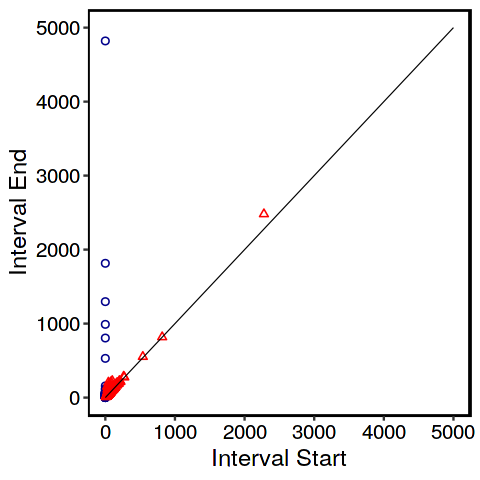

In [93]:
options(repr.plot.width=4, repr.plot.height=4)
g = ggplot()
    
beta0_bmat = dim0_finite[,2]
beta0_dmat = dim0_finite[,3]

beta1_bmat = dim1[,2]
beta1_dmat = dim1[,3]

x_max_lim = 5000

g = g + geom_point(aes(x = beta0_bmat, y = beta0_dmat), 
                   color = "darkblue", shape = 1, alpha = 1.0, size = 1.5, stroke = 0.5)
g = g + geom_point(aes(x = beta1_bmat, y = beta1_dmat), 
                   color = "red", shape = 2, alpha = 1.0, size = 1.5, stroke = 0.5)
g = g + geom_segment(aes(x = 0, y = 0, xend = x_max_lim, yend = x_max_lim), 
                   color = 'black', size = 0.25)

g = g + ylab("Interval End") + xlab("Interval Start")
g = g + xlim(0, x_max_lim) + ylim(0, x_max_lim) + theme_bw()
g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            text = element_text(colour = "black", size = 14, family = "Myriad Pro"),
            axis.text.x = element_text(colour = "black", size = 12, family = "Myriad Pro"), 
            axis.text.y = element_text(colour = "black", size = 12, family = "Myriad Pro"))
g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 1)) 
g

#### Extract cluster merging events

In [94]:
sorted_death_eps = sort(DiagAlphaCmplx$diagram[,3], index.return=TRUE)$x
sorted_death_indices = sort(DiagAlphaCmplx$diagram[,3], index.return=TRUE)$ix
length(sorted_death_indices)

[1] 823

In [14]:
cat(paste('We found fully connected clusters at eps = ', sorted_death_eps[795]))

We found fully connected clusters at eps =  180.350340410428

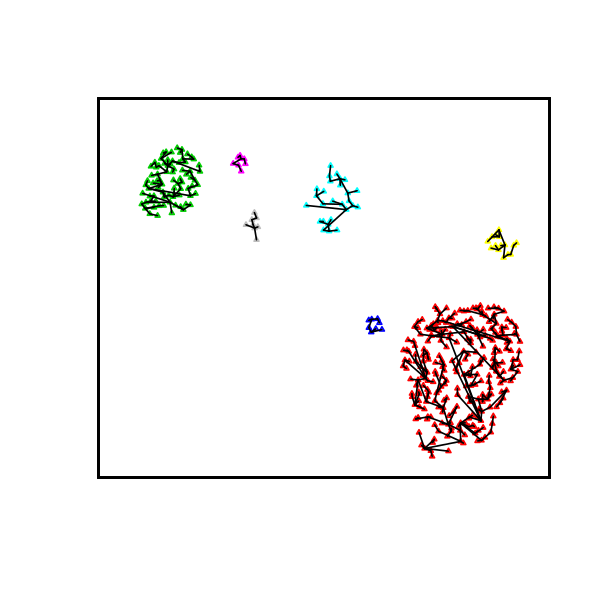

In [44]:
options(repr.plot.width=5,repr.plot.height=5)

first_plot = FALSE

for (i in seq(1, 795)){

    ind = sorted_death_indices[i]
    homology = dim(DiagAlphaCmplx$cycleLocation[ind][[1]])[2]
    
    if (homology == 1){
        
        if (first_plot == FALSE){

            plot(db, d3_filtered, cex = 0.4, yaxt='n',  xaxt='n', xlab='', ylab='', 
                 xlim=c(-12750,-12050), ylim = c(-30870,-30370))
            
            first_plot = TRUE
            
        }
            
        par(new=TRUE)
        plot(DiagAlphaCmplx$cycleLocation[ind][[1]][, ,1], DiagAlphaCmplx$cycleLocation[ind][[1]][, ,2],
        type = 'l', xlab = '', ylab = '', yaxt = 'n',  xaxt = 'n', xlim = c(-12750,-12050), ylim = c(-30870,-30370))
         
    }

}

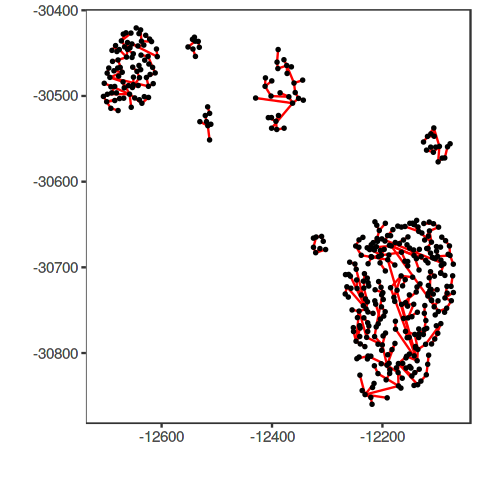

In [47]:
options(repr.plot.width=4,repr.plot.height=4)

p = ggplot()

for (i in seq(1, 795)){

    ind = sorted_death_indices[i]
    homology = dim(DiagAlphaCmplx$cycleLocation[ind][[1]])[2]
    
    if (homology == 1){
        
        TDF = data.frame(cbind(DiagAlphaCmplx$cycleLocation[ind][[1]][, ,1], DiagAlphaCmplx$cycleLocation[ind][[1]][, ,2]))
        p = p + geom_line(data = TDF, aes(x = X1, y = X2), color = "red")
    
    }
    
}

# plot the points
df = data.frame(cbind(d3_filtered[,1], d3_filtered[,2]))
p = p +  geom_point(data = df, aes(x = X1,y=X2), color = "black", size = 0.5)

# show plot
p = p + theme_bw() + theme(panel.grid.major = element_blank()) + theme(panel.grid.minor = element_blank())
p = p + ylab('') + xlab('')
p

In [52]:
saveepsfig(p, 4.4, 4.4, "A08 Connected Components", "Myriad Pro", "A08_connected_components.eps")

#### Plot barcode

Warning message:
“Removed 6 rows containing missing values (geom_segment).”Warning message:
“Removed 4 rows containing missing values (geom_segment).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 21 rows containing missing values (geom_segment).”Warning message:
“Removed 6 rows containing missing values (geom_segment).”

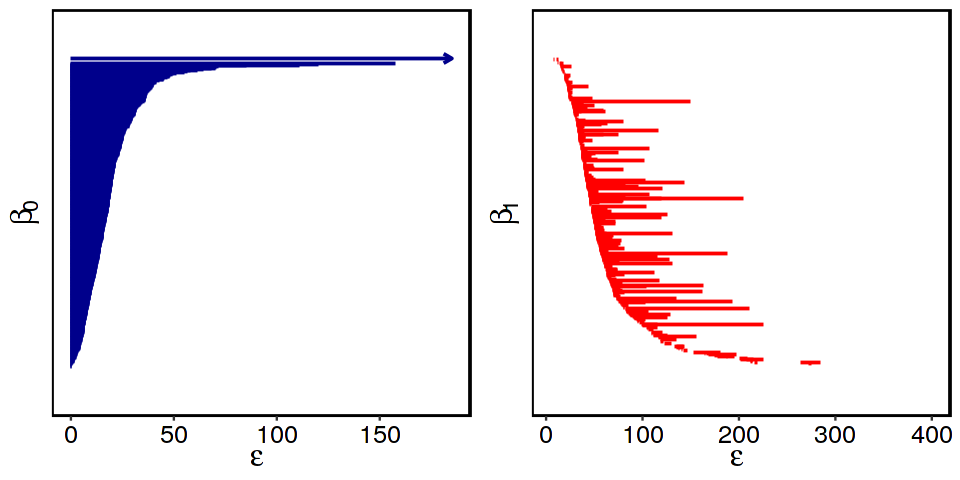

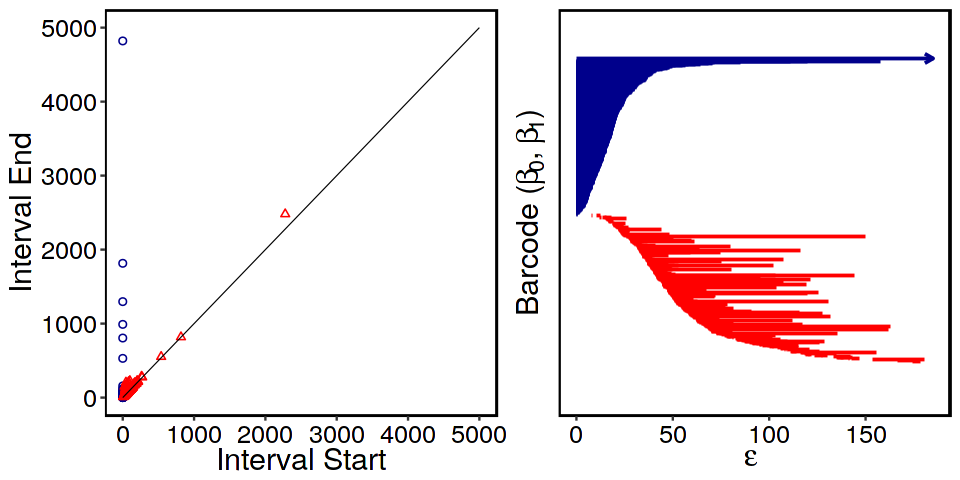

In [86]:
p1 = dim0barcode(dim0_finite, 185)
p2 = dim1barcode(dim1, 5, 400)
p3 = persistencediag(dim0_finite, dim1, 5000)
p4 = combinedbarcode(dim0_finite, dim1, 185)

options(repr.plot.width = 8, repr.plot.height = 4)
grid.newpage()
grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p2), size = "last"))
grid.newpage()
grid.draw(cbind(ggplotGrob(p3), ggplotGrob(p4), size = "last"))

#### Observations:
- Each cluster is fully connected at $\epsilon = 180$
- At higher $\epsilon$ values, the 6 merging events correspond to $7$ clusters observed in the data

#### TODO
- Does $\epsilon = 180$ correspond roughly to the diameter of the largest cluster?
- Find the $\epsilon$ value corresponding to largest cell diameter
    - Number of intervals between the $\epsilon$ values corresponding to largest cell size and largest cluster size should correspond to total number of cells
    - Number of intervals between $\epsilon$ values corresponding to largest cluster diameter and $\infty$ corresponds to number of clusters
- For each cluster merging event (6 in total):
    - Find the clusters that merged
    - Obtain the $\epsilon$ value (interval end) when the merge occured
    - Relate this value to the distance between these clusters
    
#### Figures:
- Imaris screenshot with annotated typical cell size and cluster diameters
- Nuclei positions (color-coded by cluster), showing connectivity at $\epsilon = 180$ and annotated inter-cluster distances
- Betti 0 barcode, annotated with $\epsilon$ values for largest cluster diameter and largest cell diameter, and zoomed inset
- Persistence diagram (with filtration band around barcode), zoomed inset, annotated $\epsilon$ values for merging events

In [82]:
saveepsfig(p1, 4.4, 4.4, "A08 Epithelial Betti 0", "Myriad Pro", "Wk3_IMS_TDA/OutputFiles/A08_Epithelial_Betti0.eps")
saveepsfig(p2, 4.4, 4.4, "A08 Epithelial Betti 1", "Myriad Pro", "Wk3_IMS_TDA/OutputFiles/A08_Epithelial_Betti1.eps")
saveepsfig(p3, 4.4, 4.4, "A08 Epithelial Persistence Diagram", "Myriad Pro", "Wk3_IMS_TDA/OutputFiles/A08_Epithelial_PersistencePlot.eps")
saveepsfig(p4, 4.4, 4.4, "A08 Epithelial Barcode", "Myriad Pro", "Wk3_IMS_TDA/OutputFiles/A08_Epithelial_Barcode.eps")

Warning message:
“Removed 6 rows containing missing values (geom_segment).”Warning message:
“Removed 4 rows containing missing values (geom_segment).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 21 rows containing missing values (geom_segment).”Warning message:
“Removed 6 rows containing missing values (geom_segment).”